In [35]:
import torch
import torchvision

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
# momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(batch_idx)
print(example_data.shape, example_targets.shape)

print(example_data[0].shape)
print(example_data[0][0].shape)
print(example_data[1].shape)

0
torch.Size([1000, 1, 28, 28]) torch.Size([1000])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])


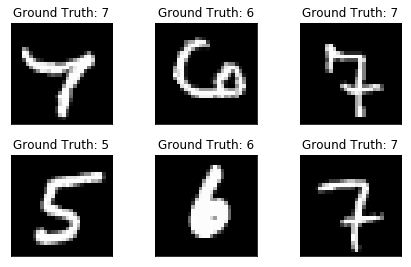

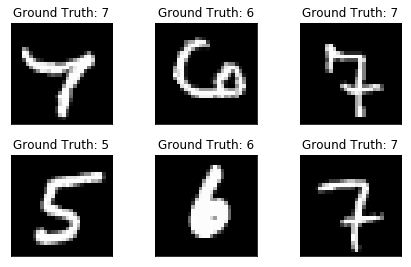

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [74]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        # layer 1
        self.conv1 = nn.Conv2d(1, 250, kernel_size=5)
        self.conv1_batch = nn.BatchNorm2d(250)
        
        # layer 2
        self.conv2 = nn.Conv2d(250, 250, kernel_size=5)
        self.conv2_batch = nn.BatchNorm2d(250)
        
        # layer 3
        self.fc1 = nn.Linear(320, 50)
        self.fc1_batch = nn.BatchNorm1d(50)
        
        # layer 4
        self.fc2 = nn.Linear(50, 10)
        self.fc2_batch = nn.BatchNorm1d(10)

    def forward(self, x):
        
        # layer 1
        x = self.conv1(x)
        print("1: ", x.shape)
        x = F.max_pool2d(x, 2)
        x = nn.functional.sigmoid(x)
        x = self.conv1_batch(x)
        print("1: ", x.shape)
        
        # layer 2
        x = self.conv2(x)
        print("2: ", x.shape)
        x = F.max_pool2d(x, 2)
        x = nn.functional.sigmoid(x)
        x = self.conv2_batch(x)
        print("2: ", x.shape)
        
        # layer 3
        x = x.view(-1, 1000)
        print("3 dupa view: ", x.shape)
        x = self.fc1(x)
        print("3 dupa fc1: ", x.shape)
        x = self.fc1_batch(x)
        print("3 dupa fc1 batch: ", x.shape)
        
        # layer 4
        x = self.fc2(x)
        print("4: ", x.shape)
        
        return F.log_softmax(x)

In [75]:
# create network and set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
network = Network()
optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))
loss_function = nn.MSELoss()

In [76]:
# init arrays for train/test errors
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]

In [77]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        output = network(data)
        print("train: ", output.shape, target.shape)
        loss = loss_function(output, target)
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [78]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += loss_function(output, target).item()

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(test_losses)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [79]:
# test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    


1:  torch.Size([64, 250, 24, 24])


D:\DISERTATIE_LUCRU\envs\data-science\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1:  torch.Size([64, 250, 12, 12])
2:  torch.Size([64, 250, 8, 8])
2:  torch.Size([64, 250, 4, 4])
3 dupa view:  torch.Size([256, 1000])


RuntimeError: size mismatch, m1: [256 x 1000], m2: [320 x 50] at c:\a\w\1\s\tmp_conda_3.7_104535\conda\conda-bld\pytorch_1550400486030\work\aten\src\th\generic/THTensorMath.cpp:940